## Residual connections to avoid vanishing gradients and make neural nets reallyyy deep

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

2024-05-07 13:22:09.738114: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 13:22:09.772091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Residual block where number of filters changes:

In [2]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
print(x.shape)
residual = x
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
print("X shape after: ", x.shape)
residual = layers.Conv2D(filters=64, kernel_size=1)(residual)
print("Residual shape: ", residual.shape)
x = layers.add([x, residual])

(None, 30, 30, 32)
X shape after:  (None, 30, 30, 64)
Residual shape:  (None, 30, 30, 64)


2024-05-07 13:22:10.715597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 13:22:10.719682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 13:22:10.719798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Residual block where the target block includes a max pooling layer:

In [3]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
print(x.shape)
residual = x
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)
print("X shape after: ", x.shape)
residual = layers.Conv2D(filters=64, kernel_size=1, strides=2)(residual)
print("Residual shape: ", residual.shape)
x = layers.add([x, residual])

(None, 30, 30, 32)
X shape after:  (None, 15, 15, 64)
Residual shape:  (None, 15, 15, 64)


In [4]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer_2[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │        128 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     18,496 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 64)  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 8, 8, 64)  │          0 │ max_pooling2d_2[… │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 8, 8, 128) │          0 │ conv2d_13[0][0],  │
│                     │                   │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_4[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
!ls

cats_vs_dogs_small  tensorflow-tutorials


In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
from pathlib import Path
base_dir = Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180,180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180,180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180,180),
    batch_size=32
)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [9]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, kernel_size=1, strides=2, padding="same", use_bias=False)(residual)

    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 176, 176,  │      2,400 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 176, 176,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 176, 176,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 176, 176,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 88, 88,    │      1,024 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 88, 88,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add_5[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 88, 88,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [10]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_seprable.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks= callbacks
)

Epoch 1/100


2024-05-07 13:23:47.529661: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.5465 - loss: 0.7597 - val_accuracy: 0.5110 - val_loss: 0.6932
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.5955 - loss: 0.6617 - val_accuracy: 0.5360 - val_loss: 0.6921
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6432 - loss: 0.6347 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6308 - loss: 0.6379 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.6647 - loss: 0.6096 - val_accuracy: 0.4990 - val_loss: 0.7102
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6709 - loss: 0.5993 - val_accuracy: 0.5000 - val_loss: 0.7428
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.6817 - loss: 0.6033 - val_accuracy: 0.5340 - val_loss: 0.7352
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.6976 - loss: 0.5791 - val_accuracy: 0.516

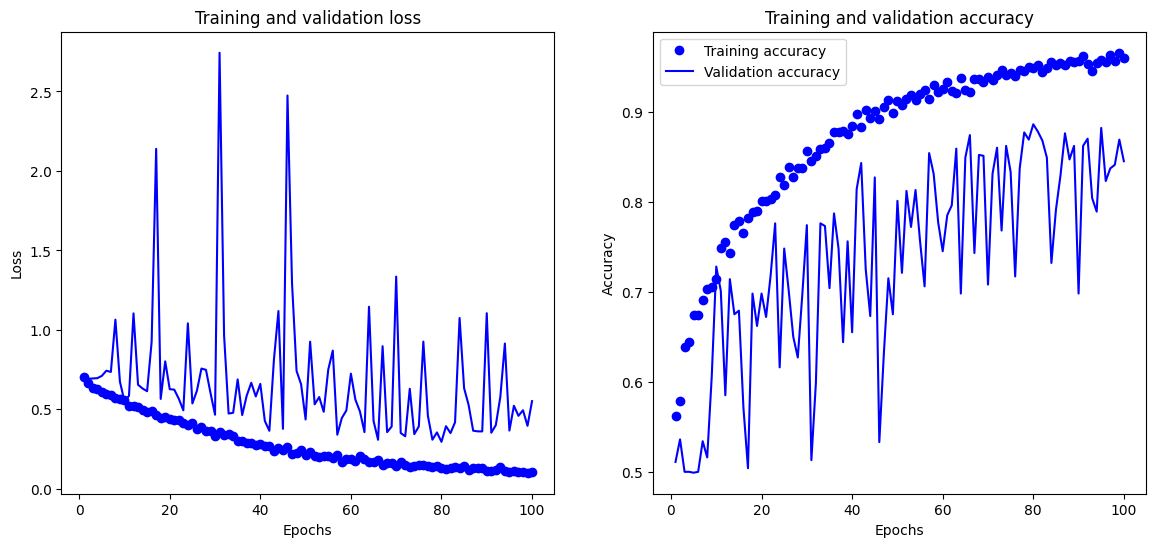

In [11]:
import matplotlib.pyplot as plt 
def plot_history(history):
    history_dict = history.history
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values)+1)
    axs[0].plot(epochs, loss_values, 'bo', label="Training loss")
    axs[0].plot(epochs, val_loss_values, 'b', label="Validation loss")
    axs[0].set_title("Training and validation loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")

    axs[1].plot(epochs, history_dict['accuracy'], 'bo', label="Training accuracy")
    axs[1].plot(epochs, history_dict['val_accuracy'], 'b', label='Validation accuracy')
    axs[1].set_ylabel("Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_title("Training and validation accuracy")
    plt.legend()
    plt.show()
plot_history(history)

In [14]:
test_model = keras.models.load_model("convnet_seprable.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8679 - loss: 0.3491
Test accuracy: 0.8744999766349792
